---
**License**

 VacuumStudy

 Mon Jun 01 09:20:00 2020
 Copyright  2020
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 VacuumStudy
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from IPython.display import HTML

from numcosmo_py import Ncm, Nc
from numcosmo_py.plotting.tools import set_rc_params_article, latex_float

%matplotlib inline

# Figure utilities

In [2]:
set_rc_params_article(ncol=2)

# Initializing the library

In [3]:
__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

[vitenti1:77774] mca_base_component_repository_open: unable to open mca_accelerator_cuda: libcuda.so.1: cannot open shared object file: No such file or directory (ignored)
[vitenti1:77774] mca_base_component_repository_open: unable to open mca_accelerator_rocm: libamdhip64.so.6: cannot open shared object file: No such file or directory (ignored)
[vitenti1:77774] mca_base_component_repository_open: unable to open mca_rcache_gpusm: libcuda.so.1: cannot open shared object file: No such file or directory (ignored)
[vitenti1:77774] mca_base_component_repository_open: unable to open mca_rcache_rgpusm: libcuda.so.1: cannot open shared object file: No such file or directory (ignored)
[vitenti1:77774] mca_base_component_repository_open: unable to open mca_coll_ucc: libucc.so.1: cannot open shared object file: No such file or directory (ignored)


# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
csq1d = Nc.DECont(Omegaw=0.3, OmegaL=0.7, w=1.0e-1, cs2=1.0e-1)
csq1d.set_reltol(1.0e-12)

ti = 1.0e-8
tf = 1.0e10

ki = 1.0e0
kf = 1.0e3
k_a = np.geomspace(ki, kf, 1000)

k = kf
csq1d.set_k(k)
csq1d.prepare_prop(None, 0.0, 1.0e-30, 1.0e1)

mylw = 1.0
ntheta = 8

theta_a = np.linspace(0.0, 2.0 * math.pi, ntheta, endpoint=False)
r_a = np.array([1.0e-04, 1.0e-03, 1.0e-02, 1.0e-1, 1.0, 3.0, 6.0])
r_a = np.geomspace(1.0e-5, 4.0e-1, 6)
colors = cm.copper(np.linspace(0, 1, len(r_a)))

In [5]:
state_prop0 = Ncm.CSQ1DState.new()
state_prop0.set_up(Ncm.CSQ1DFrame.NONADIAB1, 0.0, 0.0, 0.0)

state_prop = Ncm.CSQ1DState.new()
state_nonadiab = Ncm.CSQ1DState.new()

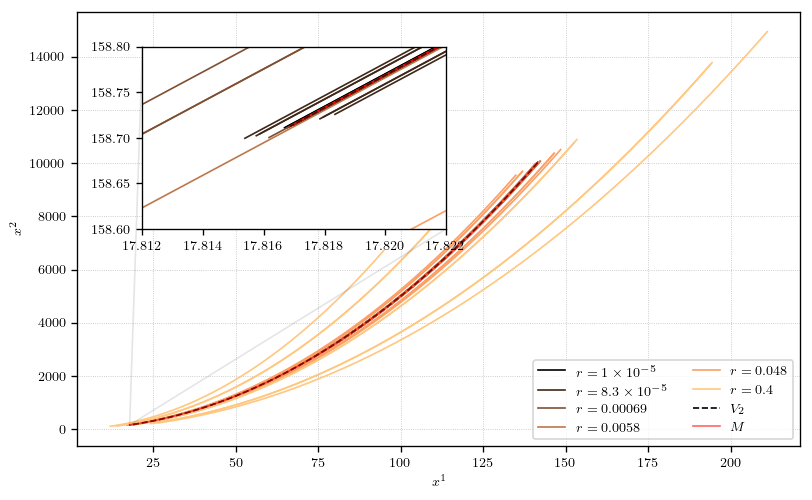

In [6]:
ti = 1.0e-8
tf = 1.0e-5

N = 2000

t_a = np.geomspace(ti, tf, N)

fig, ax = plt.subplots(dpi=120)
axin1 = ax.inset_axes([0.09, 0.5, 0.42, 0.42])

frame = Ncm.CSQ1DFrame.ORIG

evol_prop = []
evol_nonadiab = []

for t in t_a:
    csq1d.evolve_prop_vector(None, state_prop0, frame, t, state_prop)
    csq1d.compute_nonadiab(None, t, state_nonadiab)

    csq1d.change_frame(None, state_nonadiab, frame)

    evol_prop.append(state_prop.get_minkowski())
    evol_nonadiab.append(state_nonadiab.get_minkowski())

evol_prop = np.array(evol_prop)
evol_nonadiab = np.array(evol_nonadiab)

for r, c in zip(r_a, colors):
    for theta in theta_a:
        evol_circle = []
        state_prop0_circle = state_prop0.get_circle(r, theta)

        for t in t_a:
            csq1d.evolve_prop_vector(None, state_prop0_circle, frame, t, state_prop)
            evol_circle.append(state_prop.get_minkowski())
        evol_circle = np.array(evol_circle)
        
        if theta == 0:
            plt.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c, label=r"$r=%s$" % (latex_float(r)))
        else:
            plt.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c)

        axin1.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c)

plt.plot(evol_nonadiab[:,0], evol_nonadiab[:,1], "k--", lw=mylw, label=r"$V_2$", alpha=1.0)
plt.plot(evol_prop[:,0], evol_prop[:,1], "r-", lw=mylw, label=r"$M$", alpha=0.6)

axin1.plot(evol_prop[:,0], evol_prop[:,1], "r-", lw=mylw, label=r"$M$", alpha=1.0)
axin1.plot(evol_nonadiab[:,0], evol_nonadiab[:,1], "k--", lw=mylw, label=r"$V_2$", alpha=0.6)

plt.grid(which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2)

axin1.set_xlim(17.812, 17.822)
axin1.set_ylim(158.6, 158.8)

ax.indicate_inset_zoom(axin1, edgecolor="black", alpha=0.1)

plt.xlabel("$x^1$")
plt.ylabel("$x^2$")

# plt.axis('equal')
fig.tight_layout()

plt.savefig("nonadiab_vacuum_f0.pdf")
plt.show
pass

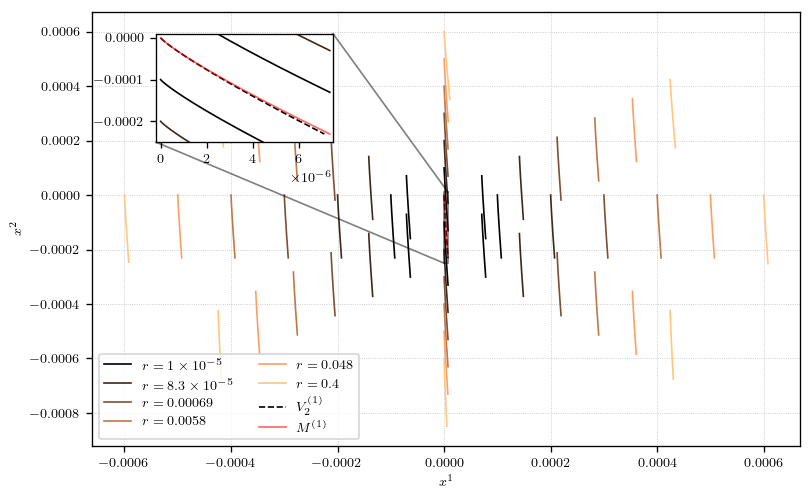

In [7]:
ti = 1.0e-8
tf = 2.2e-5

N = 2000

t_a = np.geomspace(ti, tf, N)

fig, ax = plt.subplots(dpi=120)

axin1 = ax.inset_axes([0.09, 0.7, 0.25, 0.25])

frame = Ncm.CSQ1DFrame.NONADIAB1

evol_prop = []
evol_nonadiab = []

for t in t_a:
    csq1d.evolve_prop_vector(None, state_prop0, frame, t, state_prop)
    csq1d.compute_nonadiab(None, t, state_nonadiab)

    csq1d.change_frame(None, state_nonadiab, frame)

    evol_prop.append(state_prop.get_minkowski())
    evol_nonadiab.append(state_nonadiab.get_minkowski())

evol_prop = np.array(evol_prop)
evol_nonadiab = np.array(evol_nonadiab)

l = 0.0

for r, c in zip(r_a, colors):
    for theta in theta_a:
        evol_circle = []
        state_prop0_circle = state_prop0.get_circle(r, theta)

        for t in t_a:
            csq1d.evolve_prop_vector(None, state_prop0_circle, frame, t, state_prop)
            evol_circle.append(state_prop.get_minkowski())
        evol_circle = np.array(evol_circle)

        origin = evol_circle[0]
        r0 = math.hypot(*origin)
        origin_r = origin / r0
        evol_circle = evol_circle - origin + origin_r * 1.0e-4 * (1.0 + l)

        if theta == 0:
            plt.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c, label=r"$r=%s$" % (latex_float(r)))
        else:
            plt.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c)

        axin1.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c)

    l = l + 1.0

plt.plot(evol_nonadiab[:,0], evol_nonadiab[:,1], "k--", lw=mylw, label=r"$V_2^{(1)}$", alpha=1.0)
plt.plot(evol_prop[:,0], evol_prop[:,1], "r-", lw=mylw, label=r"$M^{(1)}$", alpha=0.6)

axin1.plot(evol_nonadiab[:,0], evol_nonadiab[:,1], "k--", lw=mylw, label=r"$V_2^{(1)}$", alpha=1.0)
axin1.plot(evol_prop[:,0], evol_prop[:,1], "r-", lw=mylw, label=r"$M^{(1)}$", alpha=0.6)

plt.grid(which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="best", ncol=2)

axin1.set_xlim(-0.2e-6, +7.5e-6)
axin1.set_ylim(-25.0e-5, +1.0e-5)

ax.indicate_inset_zoom(axin1, edgecolor="black")

plt.xlabel("$x^1$")
plt.ylabel("$x^2$")

fig.tight_layout()

plt.savefig("nonadiab_vacuum_f1.pdf")
plt.show
pass

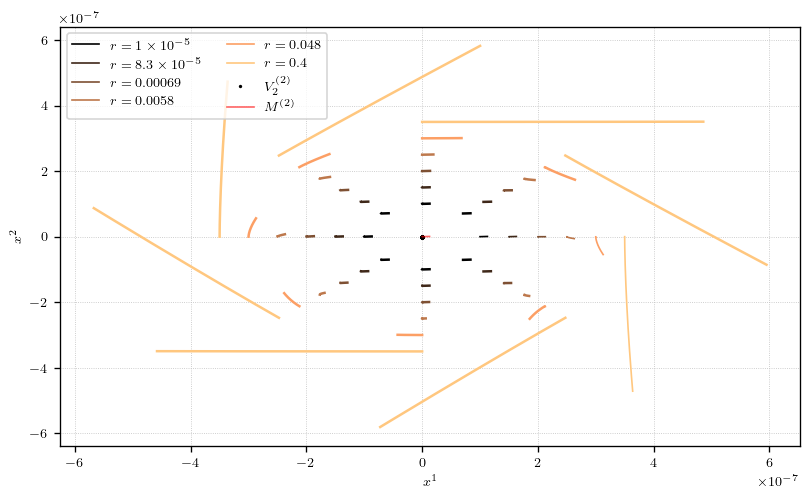

In [8]:
ti = 1.0e-8
tf = 1.0e-5

N = 2000

t_a = np.geomspace(ti, tf, N)

fig = plt.figure(dpi=120)

frame = Ncm.CSQ1DFrame.NONADIAB2

evol_prop = []
evol_nonadiab = []

for t in t_a:
    csq1d.evolve_prop_vector(None, state_prop0, frame, t, state_prop)
    csq1d.compute_nonadiab(None, t, state_nonadiab)

    csq1d.change_frame(None, state_nonadiab, frame)

    evol_prop.append(state_prop.get_minkowski())
    evol_nonadiab.append(state_nonadiab.get_minkowski())

evol_prop = np.array(evol_prop)
evol_nonadiab = np.array(evol_nonadiab)

l = 0.0
for r, c in zip(r_a, colors):
    for theta in theta_a:
        evol_circle = []
        state_prop0_circle = state_prop0.get_circle(r, theta)

        for t in t_a:
            csq1d.evolve_prop_vector(None, state_prop0_circle, frame, t, state_prop)
            evol_circle.append(state_prop.get_minkowski())
        evol_circle = np.array(evol_circle)

        origin = evol_circle[0]
        r0 = math.hypot(*origin)
        origin_r = origin / r0

        fr = 1.0e-7 * (1.0 + l / 2.0)
        evol_circle = evol_circle - origin + origin_r * fr

        if theta == 0:
            plt.plot(evol_circle[:,0], evol_circle[:,1], lw=mylw, color=c, label=r"$r=%s$" % (latex_float(r)))
        else:
            plt.plot(evol_circle[:,0], evol_circle[:,1], color=c)

    l = l + 1.0

plt.plot(
    evol_nonadiab[:,0], evol_nonadiab[:,1], "o", color="k", lw=mylw, label=r"$V_2^{(2)}$", alpha=1.0, markersize=1
)
plt.plot(evol_prop[:,0], evol_prop[:,1], "r-", lw=mylw, label=r"$M^{(2)}$", alpha=0.6)

plt.grid(which="both", linestyle=":", color="0.75", linewidth=0.5)
leg = plt.legend(loc="upper left", ncol=2)
# plt.xscale("symlog", linscale=6.0e-1, linthresh=1.0e-6)
# plt.yscale("symlog", linscale=6.0e-1, linthresh=1.0e-6)

plt.xlabel("$x^1$")
plt.ylabel("$x^2$")

# plt.axis('equal')
fig.tight_layout()

plt.savefig("nonadiab_vacuum_f2.pdf")
plt.show
pass

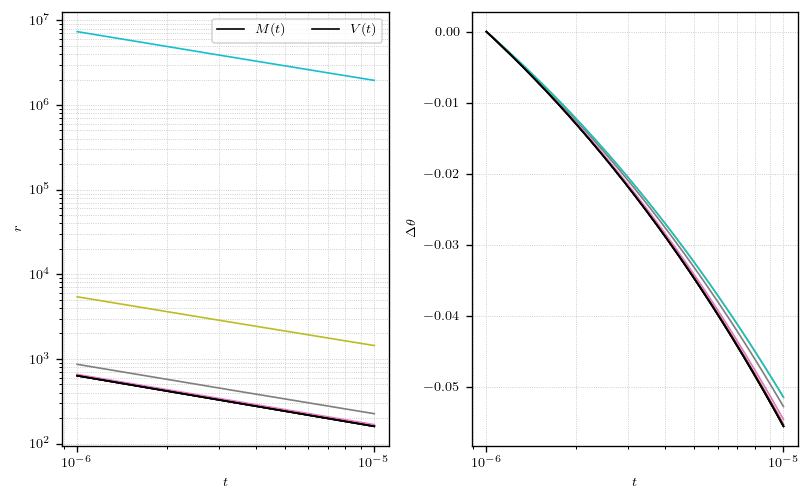

In [9]:
ti = 1.0e-6
tf = 1.0e-5

N = 2000

t_a = np.geomspace(ti, tf, N)

fig = plt.figure(dpi=120)
gs = fig.add_gridspec(1, 2)
(ax1, ax2) = gs.subplots()

frame = Ncm.CSQ1DFrame.ORIG

evol_prop = []
evol_nonadiab = []

for t in t_a:
    csq1d.evolve_prop_vector(None, state_prop0, frame, t, state_prop)
    csq1d.compute_nonadiab(None, t, state_nonadiab)

    csq1d.change_frame(None, state_nonadiab, frame)

    evol_prop.append(state_prop.get_minkowski())
    evol_nonadiab.append(state_nonadiab.get_minkowski())

evol_prop = np.array(evol_prop)
evol_nonadiab = np.array(evol_nonadiab)

for r in np.geomspace(1.0e-4, 1.0e1, 10):
    for theta in theta_a[0:1]:
        evol_circle = []
        state_prop0_circle = state_prop0.get_circle(r, theta)

        for t in t_a:
            csq1d.evolve_prop_vector(None, state_prop0_circle, frame, t, state_prop)
            evol_circle.append(state_prop.get_minkowski())
        evol_circle = np.array(evol_circle)

        rho_a = np.hypot(*np.hsplit(evol_circle, 2))
        phi_a = np.arctan2(*np.hsplit(evol_circle[:,[1,0]], 2))

        ax1.plot(t_a, rho_a, lw=mylw)
        ax2.plot(t_a, phi_a - phi_a[0], lw=mylw)

rho0_a = np.hypot(*np.hsplit(evol_prop, 2))
phi0_a = np.arctan2(*np.hsplit(evol_prop[:,[1,0]], 2))

rhoV_a = np.hypot(*np.hsplit(evol_nonadiab, 2))
phiV_a = np.arctan2(*np.hsplit(evol_nonadiab[:,[1,0]], 2))

ax1.plot (t_a, rho0_a, 'k-',  lw=mylw, label = r'$M(t)$')
ax2.plot (t_a, phi0_a-phi0_a[0], 'k-',  lw=mylw, label = r'$M(t)$')

ax1.plot (t_a, rhoV_a, 'k-',  lw=mylw, label = r'$V(t)$')
ax2.plot (t_a, phiV_a-phiV_a[0], 'k-',  lw=mylw, label = r'$V(t)$')

ax1.grid (which='both', linestyle=':', color='0.75', linewidth=0.5)
ax2.grid (which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = ax1.legend(loc="best", ncol=2)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")

ax1.set_xlabel("$t$")
ax1.set_ylabel("$r$")

ax2.set_xlabel("$t$")
ax2.set_ylabel(r"$\Delta\theta$")

# plt.axis('equal')
fig.tight_layout()

plt.savefig("nonadiab_vacuum_f0_xy.pdf")
plt.show
pass

In [10]:
csq1d = Nc.DECont(Omegaw=0.3, OmegaL=0.7, w=1.0e-3, cs2=1.0e-3)
# csq1d.set_reltol (1.0e-11)

frame = Ncm.CSQ1DFrame.ORIG
final_state = Ncm.CSQ1DState.new()

def compute_J(k):
    csq1d.set_k(k)
    csq1d.prepare_prop(None, 0.0, 1.0e-30, 1.0e1)

    csq1d.evolve_prop_vector(None, state_prop0, frame, tf, state_prop)
    csq1d.set_init_cond(None, Ncm.CSQ1DEvolState.UP, state_prop)
    csq1d.set_tf(1.0e10)
    csq1d.prepare()

    t_a, t_s = csq1d.get_time_array()

    csq1d.eval_at(t_a[-1], final_state)
    
    return final_state.get_J()

In [11]:
J_a = []
k_a = np.geomspace(1.0e-2, 1.0e3, 3000)
for k in k_a:
    J_a.append(np.array(list(compute_J(k))))

J_a = np.array(J_a)

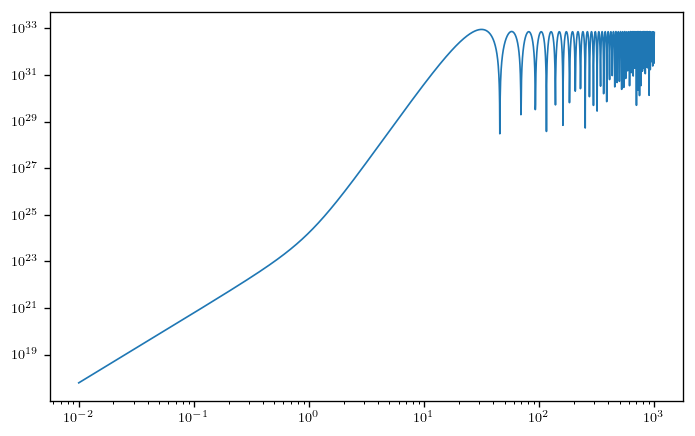

In [12]:
fig = plt.figure(dpi=120)

plt.plot(k_a, (k_a**3) * J_a[:, 0], lw=mylw, label=r"$J_{00}$")

plt.xscale("log")
plt.yscale("log")

69.02433649442632 1.0109987159727436


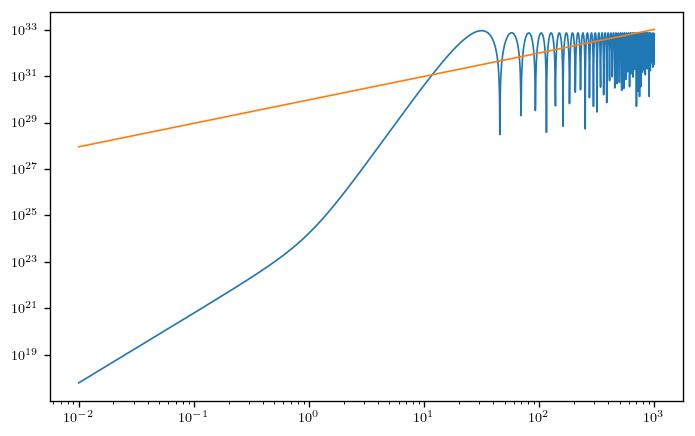

In [13]:
NPfit = 1400
k_a_fit = k_a[-NPfit:-1]
J_00_fit = J_a[-NPfit:-1, 0]

a, b = np.polyfit(np.log(k_a_fit), np.log((k_a_fit**3) * J_00_fit), 1)
print(b, a)

fig = plt.figure(dpi=120)

plt.plot(k_a, (k_a**3) * J_a[:, 0], lw=mylw, label=r"$J_{00}$")
plt.plot(k_a, np.exp(b + a * np.log(k_a)), lw=mylw, label=r"$J_{00}$")

plt.xscale("log")
plt.yscale("log")

In [14]:
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


def func(x, a, b, c):
    return a * np.sin(b * 2.0 * np.pi * x / 80.0 + np.pi * c / 2.0) ** 2


divfac = 1.0 / (5.0e32)

In [15]:
popt, pcov = curve_fit(
    func,
    k_a_fit,
    (k_a_fit**3) * J_00_fit * divfac,
    p0=[1.0, 1.0, 0.0],
    maxfev=10000,
    absolute_sigma=True,
)
# popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
# popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
# popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
# popt, pcov = curve_fit(func, k_a_fit, (k_a_fit**3)*J_00_fit*divfac,p0=popt)
print(popt)

[ 1.13319968  1.01122225 -0.49572232]


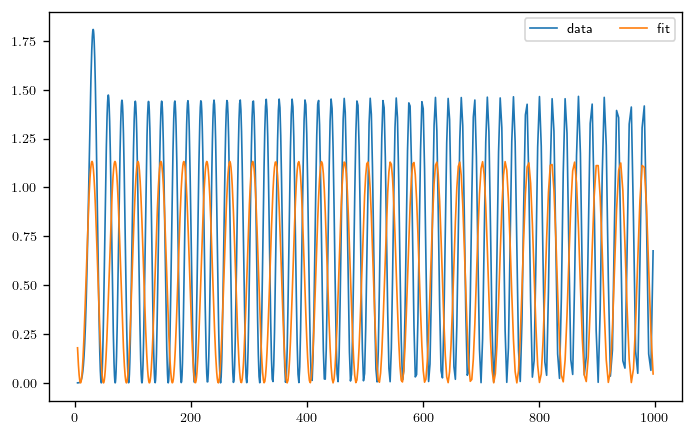

In [16]:
fig = plt.figure(dpi=120)

plt.plot(k_a_fit, (k_a_fit**3) * J_00_fit * divfac, lw=mylw, label=r"data")
plt.plot(k_a_fit, func(k_a_fit, *popt), lw=mylw, label=r"fit")
leg = plt.legend(loc="best", ncol=2)

# plt.xscale("log")
# plt.yscale("log")

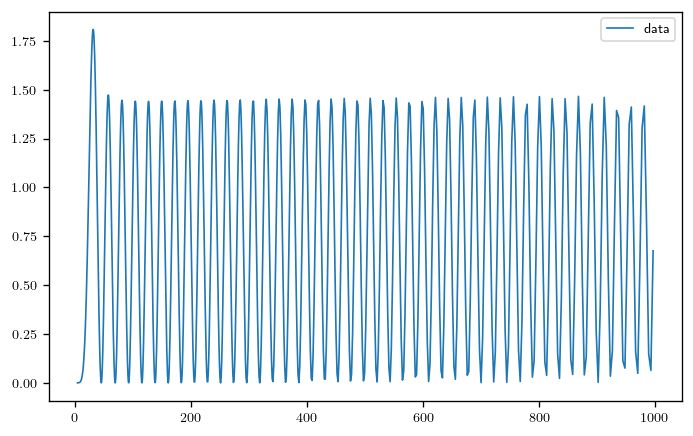

In [17]:
fig = plt.figure(dpi=120)

plt.plot(k_a_fit, k_a_fit**3 * J_00_fit * divfac, lw=mylw, label=r"data")
leg = plt.legend(loc="best", ncol=2)

# plt.xscale("log")
# plt.yscale("log")

In [18]:
np.min(J_00_fit)

1.464718726757055e+21

In [19]:
import nlopt

In [20]:
def myfunc(x, grad):
    Vtheo = func(k_a_fit, *x)
    Vdata = (k_a_fit**3) * J_00_fit * divfac

    return np.sum((Vdata - Vtheo) ** 2)


opt = nlopt.opt(nlopt.LN_NELDERMEAD, 3)
opt.set_min_objective(myfunc)
opt.set_xtol_rel(1e-8)
x = opt.optimize([1.0, 1.0, 0.0])
x = opt.optimize(x)
x = opt.optimize(x)
minf = opt.last_optimum_value()
print("optimum at ", x[0], x[1], x[2])
print("minimum value = ", minf)
print("result code = ", opt.last_optimize_result())

optimum at  1.1360422778765695 1.092556218958061 -0.5761920126385587
minimum value =  409.49641590923085
result code =  4


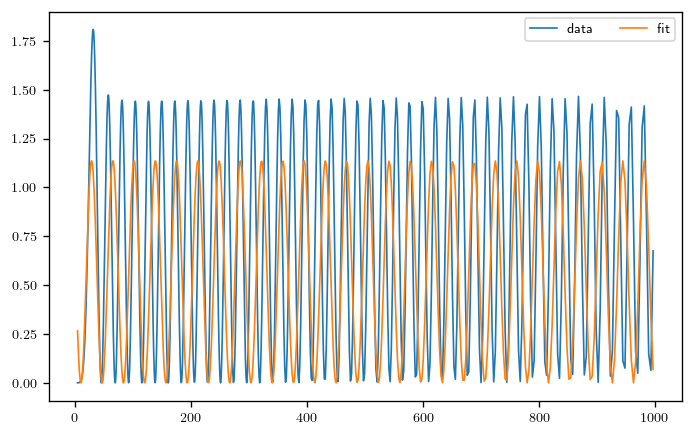

In [21]:
fig = plt.figure(dpi=120)

plt.plot(k_a_fit, (k_a_fit**3) * J_00_fit * divfac, lw=mylw, label=r"data")
plt.plot(k_a_fit, func(k_a_fit, *x), lw=mylw, label=r"fit")
leg = plt.legend(loc="best", ncol=2)